<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/jaxtrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 202 kB 4.8 MB/s 
     |████████████████████████████████| 217 kB 30.4 MB/s 
     |████████████████████████████████| 9.1 MB 26.3 MB/s 
     |████████████████████████████████| 145 kB 60.2 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 51 kB 4.8 MB/s 
     |████████████████████████████████| 72 kB 351 kB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [64]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [151]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    training:bool

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
                x=nn.Dropout(rate=0.5)(x,deterministic=not self.training)
        return x

In [152]:
layer_sizes=[64,256,256,256]
learning_rate=1e-6
epochs=500000
model=SimpleMLP(features=layer_sizes,training=True)
temp=jnp.ones(2)
key0,key1,key2=random.split(random.PRNGKey(0),3)
params=model.init({'params':key0,'dropout':key1},temp)
tx=optax.adam(learning_rate=learning_rate,b1=0.9,b2=0.999)
opt_state=tx.init(params)

In [153]:
def npy_loader(path):
    return jnp.load(path)

In [154]:
@jit
def mse_loss(params,x,y_ref):
    preds=model.apply(params,x,rngs={'dropout':key2})
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [155]:
@jit
def train_step(params,opt_state,x,y_ref):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [156]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)-1],:]
        y_batch=y_train[order[32*j:32*(j+1)-1],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch)
        train_loss=train_loss+loss
    return train_loss,params

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

100 0.28290814
200 0.20299067
300 0.16473104
400 0.14675663
500 0.13792044
600 0.13255185
700 0.12865578
800 0.12552823
900 0.12295968
1000 0.12089588
1100 0.119201206
1200 0.117800616
1300 0.11667215
1400 0.11579391
1500 0.115087986
1600 0.114528894
1700 0.11410738
1800 0.11379095
1900 0.11356514
2000 0.11339986
2100 0.11327701
2200 0.11318912
2300 0.113140926
2400 0.113133565
2500 0.11315395
2600 0.11319727
2700 0.11322369
2800 0.1132649
2900 0.11332986
3000 0.11341389
3100 0.11351232
3200 0.113627695
3300 0.11377134
3400 0.113923796
3500 0.11409676
3600 0.11429063
3700 0.11449464
3800 0.11470968
3900 0.11493761
4000 0.11517799
4100 0.115436435
4200 0.11571559
4300 0.115995474
4400 0.11628428
4500 0.11659016
4600 0.11692347
4700 0.1172777
4800 0.11764343
4900 0.118019275
5000 0.11842163
5100 0.11881968
5200 0.119227216
5300 0.119650304
5400 0.120092444
5500 0.12055033
5600 0.1210149
5700 0.12149675
5800 0.121999115
5900 0.12251837
6000 0.12306316
6100 0.12363905
6200 0.124233246
6300

KeyboardInterrupt: ignored

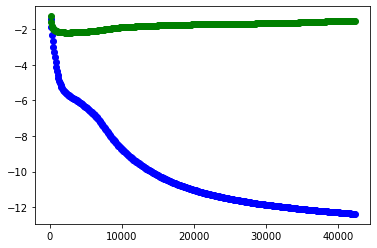

In [159]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order)
    if i % 100 == 99:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate)
        print((i+1),validate_loss)
        plt.scatter((i+1),jnp.log(train_loss),c='b')
        plt.scatter((i+1),jnp.log(validate_loss),c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.xlabel("Epoch")
plt.ylabel("ln(loss)")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")
drive.flush_and_unmount()

In [ ]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=input_result[900:1000,:]
model_eval=SimpleMLP(features=layer_sizes,training=False)
y_pred=model_eval.apply(params,x_test)
print(y_pred)
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")